In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')

#select the variables we need
all_vars = df[['Hobbyist', 'ConvertedComp', 'Employment','EdLevel', 'Gender', 'JobSat', 'NEWOnboardGood', 'NEWOtherComms', 'NEWOvertime', 'WorkWeekHrs']]
#Drop all the rows with na
all_vars = all_vars.dropna()

#keep data with only employed
#all_vars = all_vars[-all_vars.Employment.isin(['Not employed, but looking for work', 'Not employed, and not looking for work', 'Student', 'Retired', 'I prefer not to say'])]

#keep data with those know the boarding
all_vars = all_vars[all_vars.NEWOnboardGood.isin(['Yes', 'No'])]

#labeling, transform variables to numeric
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
#trans 'yes' to 1, 'no' to 2
for col in all_vars[['Hobbyist','NEWOnboardGood', 'NEWOtherComms']]:
    all_vars[col]=le.fit_transform(all_vars[col])

#mapping, transform variables to numeric
Gender_mapping = {'Man':0,'Woman':1}
JobSat_mapping = {'Very dissatisfied':-2,'Slightly dissatisfied':-1, 'Neither satisfied nor dissatisfied':0, 'Slightly satisfied':1, 'Very satisfied':2}
EdLevel_mapping = {'I never completed any formal education':0,'Primary/elementary school':0, 'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)':0, 'Some college/university study without earning a degree':0, 'Associate degree (A.A., A.S., etc.)':1, 'Bachelor’s degree (B.A., B.S., B.Eng., etc.)':2, 'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)':3, 'Professional degree (JD, MD, etc.)':4, 'Other doctoral degree (Ph.D., Ed.D., etc.)':4}
NEWOvertime_mapping = {'Never':0,'Rarely: 1-2 days per year or less':1, 'Occasionally: 1-2 days per quarter but less than monthly':2, 'Sometimes: 1-2 days per month but less than weekly':3, 'Often: 1-2 days per week or more':4}
Employment_mapping = {'Employed full-time':0,'Employed part-time':1, 'Independent contractor, freelancer, or self-employed':2}

all_vars['Gender'] = all_vars['Gender'].map(Gender_mapping)
all_vars['JobSat'] = all_vars['JobSat'].map(JobSat_mapping)
all_vars['EdLevel'] = all_vars['EdLevel'].map(EdLevel_mapping)
all_vars['NEWOvertime'] = all_vars['NEWOvertime'].map(NEWOvertime_mapping)
all_vars['Employment'] = all_vars['Employment'].map(Employment_mapping)


In [2]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test



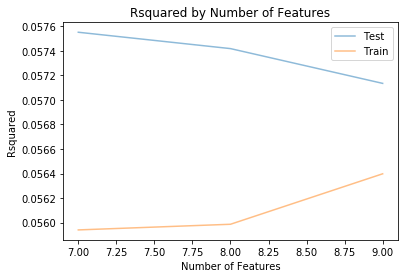

In [4]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]
all_vars = all_vars.dropna()
y = all_vars['JobSat']
X = all_vars.drop(['JobSat'], axis = 1)

#Run this cell to pass your X and y to the model for testing
r2_scores_test, r2_scores_train, lm_model, X_test, X_train, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)


In [ ]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

In [ ]:
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2